# Short-term Temperature Model Test

## Import dependencies and data

In [51]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

In [52]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [53]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [54]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('state', 'TA01_output'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'hourofday')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [55]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
state         TA01_output         15
temperatures  DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      11
              DC_GT104_GM104      11
              DC_GT401_GM401      13
              TA01_GT401_GM401    13
              TA02_GT401_GM401    12
              DC_GT301_damped     12
              DC_GT301_outdoor    12
humidity      DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      12
              DC_GT104_GM104      10
              DC_GT401_GM401      14
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  2
              gsi_deriv            2
              vol                  2
              vol_deriv            2
time          dayofyear            2
              monthofyear          2
              minofday             2
              hourofday            2
dtype: int64





In [56]:
# remove single NAN
data = data.dropna(how='any')

In [58]:
# # reduce to one OBS per MIN
data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

# remove APRIL data
data = data[data.index.get_level_values(0) != 4]

## Feature engineering

### GH Temperature

In [60]:
### create "better" estimate of temperature var, w. proper avg.
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [61]:
# adjust for setpoint change
col1 = ('temperatures', 'TA01_GT10X_GM10X')
# col2 = ('setpoints', 'TA01_GT10X_GM10X')
# data[col1] = data[col1] - data[col2]

# set min to zero
# data[col1] = data[col1] + abs(data[col1].min())

# # min-max scale, i.e. squeeze into [0, 1]
#data[col1] = (data[col1] - data[col1].min()) / (data[col1].max() - data[col1].min())


### DC temperature

In [62]:
### min-max scale [btween 0 and 1]
col = ('temperatures', 'DC_GT401_GM401')
col2 = ('temperatures', 'DC_GT401_GM401_scaled')
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### scale by fan output
# data[col2] = data[col] * data[('state', 'TA01_output')] / data[('state', 'TA01_output')].min()
data[col2] = data[col] * data[('flow', 'TA01_GP101')] / data[('flow', 'TA01_GP101')].min()

### OUTSIDE temperature

In [63]:
### normalize vals
col = ('temperatures', 'DC_GT301_damped')

#min-max scale vals
#set MIN to zero
data[col] = data[col] + abs(data[col].min())
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### GH Humidity

In [64]:
### create "better" estimate of temperature var, w. proper avg.
data[('humidity', 'TA01_GT10X_GM10X')] = data.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [65]:
### normalize humidity
col = ('humidity', 'TA01_GT10X_GM10X')

# min-max scale vals
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### Solar radiance

In [66]:
# ### min-max scale GSI
col = ('sun', 'gsi')
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

In [67]:
### zero-centered variance scale GSI deriv
col = ('sun', 'gsi_deriv')

data[col] = data[col] + abs(data[col].min())
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### Flow volume

In [68]:
### create INDICATOR variable f. TA01_output
data[('state', 'TA01_bool')] = data.state.TA01_output.apply(lambda val: val > 35)

In [69]:
# ### ..
col = ('flow', 'TA01_GP101')
# col2 = ('flow', 'TA01_GP101_scaled')

# # create another version of flow
# data[col2] = data[col].copy()

# ### min-max scale flow (i.e. squeeze into [0, 1])
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

# ### min-max scale w.r.t. indicator variable
# mask = data[('state', 'TA01_output')].values
# data.loc[mask, col2] = (data[mask][col2] - data[mask][col2].min()) / (data[mask][col2].max() - data[mask][col2].min())
# data.loc[~mask, col2] = (data[~mask][col2] - data[~mask][col2].min()) / (data[~mask][col2].max() - data[~mask][col2].min())

## Kalman filtering

In [70]:
cols = [
    (('temperatures', 'TA01_GT10X_GM10X'), 3),
    (('temperatures', 'DC_GT401_GM401'), 2),
    (('temperatures', 'DC_GT401_GM401_scaled'), 2),
    (('temperatures', 'DC_GT301_damped'), 4),
    (('humidity', 'TA01_GT10X_GM10X'), 3),
    
]

for colSpec in cols:
    # apply KALMAN filter to temperature measurements
    col = colSpec[0]
    varExp = colSpec[-1]
    
    # get data
    X = data[col].values
    n = len(X)

    # process variance, measurement variance
    Q = 1e-5
    R = 0.1**varExp

    xhat=np.zeros(n)      # a posteri estimate of x
    P=np.zeros(n)         # a posteri error estimate
    xhatminus=np.zeros(n) # a priori estimate of x
    Pminus=np.zeros(n)    # a priori error estimate
    K=np.zeros(n)         # gain or blending factor

    # intial guesses
    xhat[0] = X[0]
    P[0] = X[1]

    for k in range(1,n):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    data[col] = xhat

## Data preparation

In [71]:
t_steps = 10   # 10-min predictions
n_steps = 30   # 20-min backwards look

train_frac = 0.9

### Data selection and split

In [229]:
# Define model variables
model_vars = [
    ('temperatures', 'TA01_GT10X_GM10X'),
#     ('flow', 'TA01_GP101'),
#     ('flow', 'TA01_GP101_scaled'),
#     ('state', 'TA01_output'),
#     ('state', 'TA01_bool'),
    ('temperatures', 'DC_GT401_GM401_scaled'),
#     ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('time', 'minofday'),
    #('time', 'hourofday'),
    #('time', 'dayofyear'),
    #('time', 'monthofyear')
]

# filter data
testData = data[model_vars].copy()

In [230]:
targets = testData.pop(('temperatures', 'TA01_GT10X_GM10X')).copy()
targets = (targets - targets.shift(t_steps)) * 10

### Create sequences

In [231]:
def date_flagger(data, n_steps):
    # get flagged datesvalues
#     data['minute'] = data.index.get_level_values(3).values    
#     data['date_flag'] = data.minute - data.minute.shift(n_steps) != (n_steps)

    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [232]:
# get all n_step-sequences from data series
vals = testData.values
sequences = []
for i in range(len(testData) - n_steps):
    sequences.append(vals[i:i+n_steps])
    
sequences = np.stack(sequences)

In [233]:
# get flagged sequences
flags = date_flagger(testData, n_steps)

# get mask f. flags
mask = [idx not in flags for idx in range(len(sequences))]
sequences = sequences[mask][:-t_steps]

# get targets, delete mask
targets = targets.values[n_steps:][mask][:-t_steps]

In [234]:
# save sequential targets for visualization
targets, test_targets = targets[:-5760], targets[-5760:]
sequences, test_sequences = sequences[:-5760], sequences[-5760:]

### Shuffle and split dataset

In [235]:
# get random indices
idxs = np.arange(len(targets))
np.random.shuffle(idxs)

# shuffle sequences and targets
targets = np.squeeze(targets[idxs])
sequences = np.squeeze(sequences[idxs])

In [236]:
# split data
train_n = int(len(targets) * train_frac)
X_train, X_test = sequences[:train_n], sequences[train_n:]
Y_train, Y_test = targets[:train_n], targets[train_n:]

In [237]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

## Define LSTM Regressor

In [315]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
        X_train.shape[2]
    )),
    layers.LSTM(
        units=64,
        return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2,
        #dropout=0.2,
        kernel_initializer=tf.keras.initializers.GlorotNormal()
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
        return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.5,
        #dropout=0.5,
        kernel_initializer=tf.keras.initializers.GlorotNormal()
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
#         return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.5,
        #dropout=0.5,
        kernel_initializer=tf.keras.initializers.GlorotNormal()
    ),
    layers.BatchNormalization(),
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [316]:
# lr = 0.005
# lr = 0.001
lr = 0.0005
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 30, 64)            18176     
                                                                 
 batch_normalization_30 (Bat  (None, 30, 64)           256       
 chNormalization)                                                
                                                                 
 lstm_31 (LSTM)              (None, 30, 32)            12416     
                                                                 
 batch_normalization_31 (Bat  (None, 30, 32)           128       
 chNormalization)                                                
                                                                 
 lstm_32 (LSTM)              (None, 32)                8320      
                                                                 
 batch_normalization_32 (Bat  (None, 32)               128   

In [317]:
model2 = tf.keras.models.load_model(save_path + 'temp_diff_model_v52')
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            18176     
                                                                 
 batch_normalization_12 (Bat  (None, 30, 64)           256       
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 30, 32)            12416     
                                                                 
 batch_normalization_13 (Bat  (None, 30, 32)           128       
 chNormalization)                                                
                                                                 
 lstm_14 (LSTM)              (None, 32)                8320      
                                                                 
 batch_normalization_14 (Bat  (None, 32)               128   

In [318]:
# copy weigths from pre-trained
for idx, layer in enumerate(model.layers):
    layer.set_weights(model2.layers[idx].get_weights())

In [ ]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/10
  99/3266 [..............................] - ETA: 7:24 - loss: 1.7563

In [285]:
# model_name = 'temp_diff_model_v53'
# model.save(save_path + model_name)

INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\temp_diff_model_v52\assets


INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\temp_diff_model_v52\assets


In [ ]:
# model = tf.keras.models.load_model(save_path + 'temp_diff_model_v51')
# model.summary()

In [300]:
preds = model.predict(X_test)
vis_preds = model.predict(test_sequences.astype('float64'))

180/180 [==============================] - 5s 29ms/step


In [109]:
# # get data
# X = vis_preds.copy()
# n = len(X)

# # process variance, measurement variance
# Q = 1e-5
# R = 0.1**4

# xhat=np.zeros(n)      # a posteri estimate of x
# P=np.zeros(n)         # a posteri error estimate
# xhatminus=np.zeros(n) # a priori estimate of x
# Pminus=np.zeros(n)    # a priori error estimate
# K=np.zeros(n)         # gain or blending factor

# # intial guesses
# xhat[0] = X[0]
# P[0] = X[1]

# for k in range(1,n):
#     # time update
#     xhatminus[k] = xhat[k-1]
#     Pminus[k] = P[k-1]+Q

#     # measurement update
#     K[k] = Pminus[k]/( Pminus[k]+R )
#     xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
#     P[k] = (1-K[k])*Pminus[k]


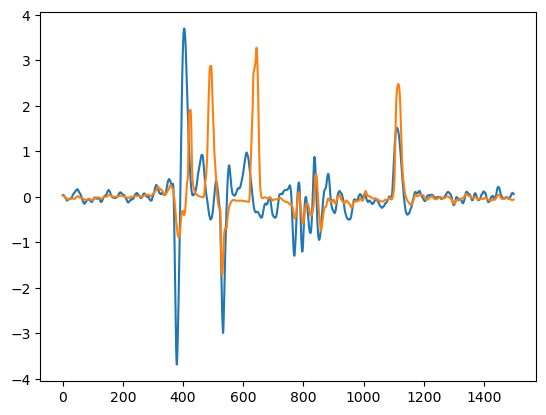

In [301]:
plt.plot(test_targets[:1500] / 10)
plt.plot(vis_preds[:1500] / 10)
# plt.plot(xhat[:2000])

In [254]:
test_mae = np.abs(np.squeeze(preds / 10) - Y_test / 10) 
temp_diffs = test_mae

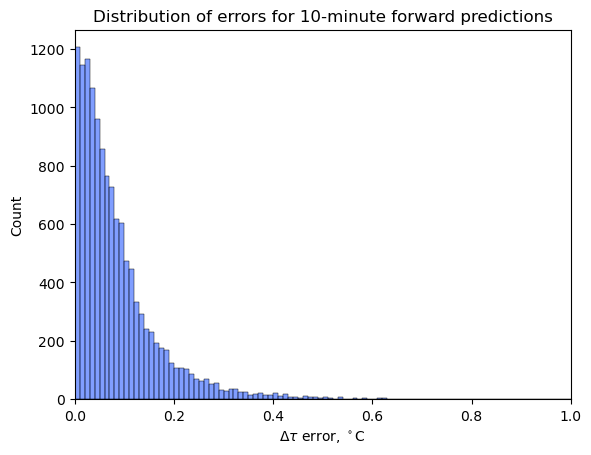

In [255]:
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[0, 1.0],
    kde=False,
    palette='bright',
    legend=False
)

plt.title('Distribution of errors for 10-minute forward predictions')
plt.xlim(0, 1.0)
plt.xlabel('$\Delta \\tau$ error, $^\circ$C')

# plt.savefig(plot_path + 'temp_error_dist.png', bbox_inches='tight', dpi=200)
plt.show()

In [282]:
exp_seqs = test_sequences.copy().astype('float64')
exp_seqs[:, -10:, 0] += 0.1
exp_preds = model.predict(exp_seqs)

180/180 [==============================] - 5s 26ms/step


In [283]:
np.max(exp_seqs)

1.6958717013418092

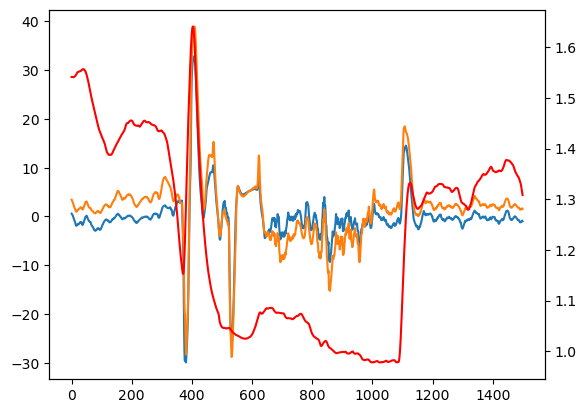

In [284]:
fig, ax1 = plt.subplots()
ax1.plot(vis_preds[:1500])
ax1.plot(exp_preds[:1500])

ax2 = ax1.twinx()
ax2.plot(exp_seqs[:1500, -1, 0], 'r')

In [ ]:
# preds = []
# exp_seqs = test_sequences.copy().astype('float64')
# exp_auxData = test_auxData.copy()
# for idx, seq in enumerate(exp_seqs):
#     if (idx % 500 == 0) and (idx > 0):
#         print(idx)
    
# #     for n in range(n_steps-t_steps):
# #         exp_seqs[idx+n, -(t_steps+n):-n, 0] += error

# #     seq[-t_steps:, 0] -= 0.3
#     pred = model.predict([seq[np.newaxis, ...], exp_auxData[idx][np.newaxis, ...]], verbose=False)

#     preds.append(pred[0][0])
#     exp_auxData[idx + t_steps] = exp_auxData[idx] + pred / 10
        
    